In [1]:
import torch
import torchvision

In [2]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [3]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [5]:
example_data.shape

torch.Size([1000, 1, 28, 28])

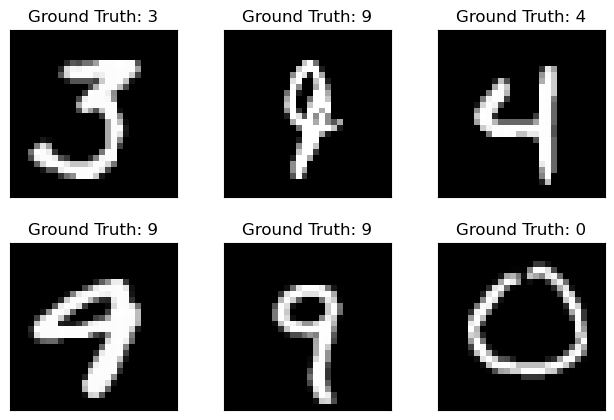

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure()

for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
#fig

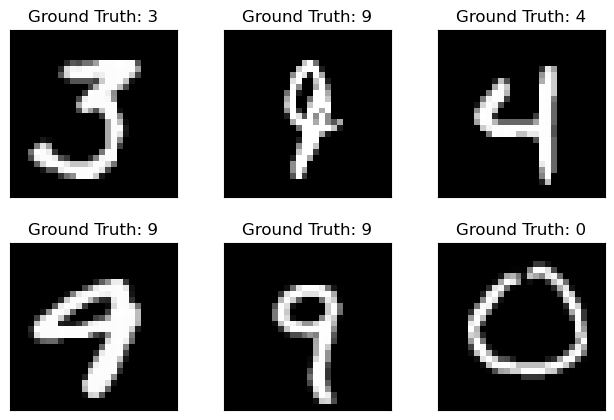

In [7]:
fig

In [8]:
for i in range(6):
    print(i)

0
1
2
3
4
5


In [9]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [11]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)


In [12]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [13]:
import os

def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

       # Ensure directory exists
      save_dir = './results'
      os.makedirs(save_dir, exist_ok=True) 
      torch.save(network.state_dict(), 'model.pth')
      torch.save(optimizer.state_dict(), 'optimizer.pth')

In [14]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [15]:
test()

/var/folders/c_/kmq275hx6xvflqnbfp5t2vk80000gp/T/ipykernel_51877/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
/opt/anaconda3/lib/python3.12/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3096, Accuracy: 924/10000 (9%)



In [16]:
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.325928
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.287777
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.281435


/var/folders/c_/kmq275hx6xvflqnbfp5t2vk80000gp/T/ipykernel_51877/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.243744
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.264606
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.240564
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.153203
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.211478
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.056572
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.010396
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.009824
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.866547
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.754715
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.616294
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.411785
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.598946
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.262779
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.320824
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.231845
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.044263
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.130787
Train Epoch: 1 [13440/60000 (22%)]	Loss: 1.002073
Train Epoch: 1 [14080/60000 (23%)]	Loss: 1.336472
Train Epoch: 1 [147

Text(0, 0.5, 'negative log likelihood loss')

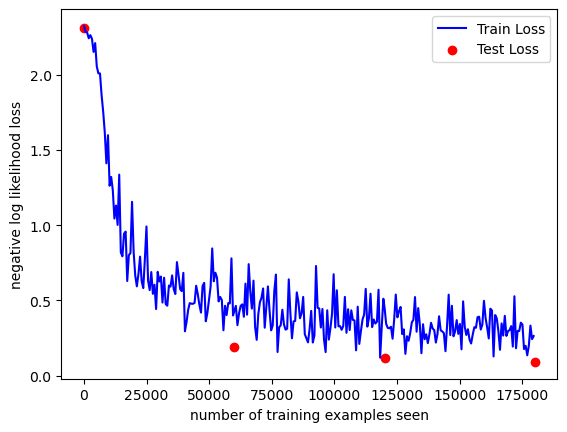

In [17]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

In [18]:
with torch.no_grad():
  output = network(example_data)

/var/folders/c_/kmq275hx6xvflqnbfp5t2vk80000gp/T/ipykernel_51877/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


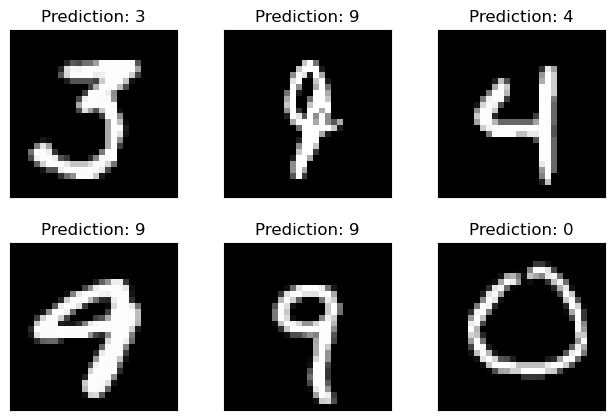

In [19]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])

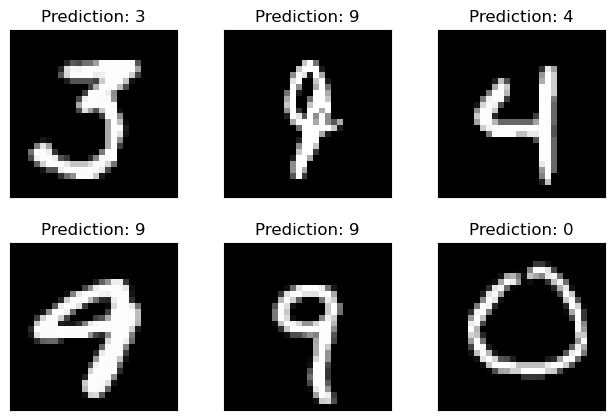

In [56]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])

In [21]:
continued_network = Net()
continued_optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                                momentum=momentum)

In [22]:
network_state_dict = torch.load("./results/model.pth")
continued_network.load_state_dict(network_state_dict)

optimizer_state_dict = torch.load("./results/optimizer.pth")
continued_optimizer.load_state_dict(optimizer_state_dict)

/var/folders/c_/kmq275hx6xvflqnbfp5t2vk80000gp/T/ipykernel_51877/390688385.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  network_state_dict = torch.load("./results/mod

In [23]:
for i in range(4,9):
  test_counter.append(i*len(train_loader.dataset))
  train(i)
  test()

/var/folders/c_/kmq275hx6xvflqnbfp5t2vk80000gp/T/ipykernel_51877/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 4 [0/60000 (0%)]	Loss: 0.324272
Train Epoch: 4 [640/60000 (1%)]	Loss: 0.300369
Train Epoch: 4 [1280/60000 (2%)]	Loss: 0.275442
Train Epoch: 4 [1920/60000 (3%)]	Loss: 0.182517
Train Epoch: 4 [2560/60000 (4%)]	Loss: 0.252034
Train Epoch: 4 [3200/60000 (5%)]	Loss: 0.208360
Train Epoch: 4 [3840/60000 (6%)]	Loss: 0.379010
Train Epoch: 4 [4480/60000 (7%)]	Loss: 0.371962
Train Epoch: 4 [5120/60000 (9%)]	Loss: 0.259307
Train Epoch: 4 [5760/60000 (10%)]	Loss: 0.174010
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.405984
Train Epoch: 4 [7040/60000 (12%)]	Loss: 0.296486
Train Epoch: 4 [7680/60000 (13%)]	Loss: 0.145383
Train Epoch: 4 [8320/60000 (14%)]	Loss: 0.173262
Train Epoch: 4 [8960/60000 (15%)]	Loss: 0.195675
Train Epoch: 4 [9600/60000 (16%)]	Loss: 0.191500
Train Epoch: 4 [10240/60000 (17%)]	Loss: 0.170527
Train Epoch: 4 [10880/60000 (18%)]	Loss: 0.115756
Train Epoch: 4 [11520/60000 (19%)]	Loss: 0.447888
Train Epoch: 4 [12160/60000 (20%)]	Loss: 0.204012
Train Epoch: 4 [12800/60000 (

Text(0, 0.5, 'negative log likelihood loss')

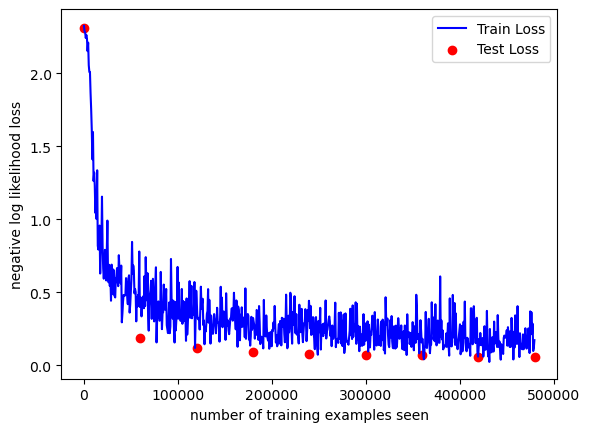

In [24]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

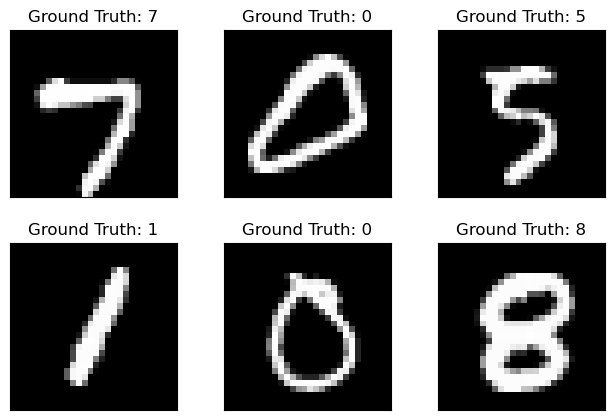

Predicted labels:  [7, 0, 5, 1, 0, 8, 4, 9, 3, 8, 4, 4, 2, 8, 3, 9, 2, 6, 6, 8, 2, 5, 2, 5, 5, 5, 8, 0, 2, 7, 9, 1, 9, 2, 1, 1, 2, 0, 1, 9, 5, 1, 0, 5, 0, 1, 8, 3, 3, 0, 5, 7, 8, 9, 7, 8, 4, 6, 8, 7, 8, 9, 3, 1, 4, 2, 5, 9, 1, 3, 4, 1, 5, 7, 3, 3, 5, 7, 5, 2, 3, 7, 0, 2, 4, 4, 1, 3, 6, 6, 3, 7, 5, 8, 5, 6, 2, 6, 0, 8, 6, 0, 2, 3, 1, 6, 1, 4, 1, 2, 0, 3, 2, 7, 4, 6, 8, 3, 1, 2, 1, 1, 1, 2, 0, 5, 7, 5, 3, 1, 0, 0, 7, 6, 1, 3, 0, 3, 1, 6, 2, 2, 4, 8, 5, 6, 7, 1, 0, 4, 4, 2, 8, 3, 2, 0, 0, 2, 6, 1, 8, 8, 1, 0, 7, 2, 1, 1, 9, 8, 0, 4, 7, 6, 7, 9, 8, 1, 6, 6, 3, 7, 9, 8, 6, 4, 4, 8, 6, 4, 9, 7, 6, 9, 5, 4, 4, 4, 9, 3, 3, 0, 8, 4, 2, 1, 9, 0, 3, 5, 4, 2, 0, 1, 5, 1, 9, 5, 0, 5, 9, 6, 1, 8, 4, 8, 7, 9, 3, 2, 7, 2, 2, 1, 0, 7, 7, 5, 8, 8, 8, 5, 4, 4, 5, 9, 8, 0, 3, 0, 1, 5, 6, 8, 4, 1, 7, 1, 2, 6, 5, 8, 8, 0, 2, 2, 1, 0, 1, 9, 9, 3, 3, 1, 7, 0, 9, 1, 3, 1, 7, 3, 2, 2, 9, 9, 0, 1, 2, 0, 2, 7, 0, 9, 4, 1, 4, 5, 3, 9, 6, 9, 9, 6, 8, 2, 7, 7, 9, 8, 7, 5, 7, 3, 6, 6, 4, 4, 6, 8, 8, 5, 9, 9, 7, 6, 7,

/var/folders/c_/kmq275hx6xvflqnbfp5t2vk80000gp/T/ipykernel_51877/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [58]:
examples = enumerate(test_loader)  # Create a new enumerator
batch_idx, (example_data, example_targets) = next(examples)  # Retrieve a new batch

# Visualize the new batch of images
fig = plt.figure()
for i in range(6):  # Show the first 6 images
    plt.subplot(2, 3, i + 1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i].item()))  # Show true label
    plt.xticks([])
    plt.yticks([])
plt.show()

# Pass the new batch through your model
network.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculation
    output = network(example_data)  # Get model predictions
    predicted_labels = output.data.max(1, keepdim=True)[1]  # Get the predicted labels

# Compare predictions with the actual labels
print("Predicted labels: ", predicted_labels.squeeze().tolist())
print("Ground Truth labels: ", example_targets.tolist())